# Trabalho Data Harvesting

## Configurando Ambiente

### Criando ambiente isolado

In [1]:
!python -m venv .venv
!source .venv/bin/activate

### Instalando Dependências

In [2]:
%pip install -q -r requirements.txt


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## 1. Definindo ações a serem analisadas

In [3]:
acoes = [
    'PETR4',
    'ITSA4',
    'TAEE11',
    'BBAS3',
    'BBDC3',
    'BBSE3',
    'VIVT3',
    'NEOE3',
    'CMIG4',
]

## 2. Definindo metodos a serem utilizados na analise

### 2.1 Coleta das manchetes

In [4]:
from bs4 import BeautifulSoup
from selenium import webdriver
import time

options = webdriver.ChromeOptions()
# options.add_argument('--headless')  # Executa o navegador em segundo plano
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')


# Função para coletar manchetes de notícias
def coletar_manchetes(ticker, driver=None, scroll_down_times=1):
    url = f'https://news.google.com/search?q={ticker}&hl=pt-BR'
    closeDriver = False
    if driver is None:
        closeDriver = True
        driver = webdriver.Chrome(options=options)
    driver.get(url)
    
    for _ in range(scroll_down_times):
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(1)  # Espera o carregamento do conteúdo

    content = driver.page_source
    soup = BeautifulSoup(content, 'html.parser')
    articles = soup.find_all('article')
    headlines = [a.find('a', tabindex='0').text for a in articles]

    if closeDriver:
        driver.quit()
    return headlines

def coletar_manchetes_tickers(tickers, scroll_down_times=1):
    driver = webdriver.Chrome(options=options)
    manchetes = {}
    for ticker in tickers:
        manchetes[ticker] = coletar_manchetes(ticker, driver=driver, scroll_down_times=scroll_down_times)
    driver.quit()
    return manchetes


### 2.2 Analise de sentimentos

In [5]:
from textblob import TextBlob

# Função para analisar o sentimento das manchetes
def analisar_sentimento(manchetes):
    sentimentos = [TextBlob(headline).sentiment.polarity for headline in manchetes]
    return sentimentos

In [6]:
# Coletar manchetes para cada ação
manchetes = coletar_manchetes_tickers(acoes)

In [7]:
manchetes

# imprima quantas manchetes foram coletadas para cada ação
for ticker, headlines in manchetes.items():
    print(f'{ticker}: {len(headlines)} manchetes')

PETR4: 102 manchetes
ITSA4: 100 manchetes
TAEE11: 100 manchetes
BBAS3: 100 manchetes
BBDC3: 100 manchetes
BBSE3: 100 manchetes
VIVT3: 100 manchetes
NEOE3: 100 manchetes
CMIG4: 100 manchetes


In [8]:
# Analisar o sentimento para cada ação
sentimentos = {ticker: analisar_sentimento(manchetes[ticker]) for ticker in acoes}

In [9]:
import pandas as pd

# Calcular o sentimento médio para cada ação
media_sentimentos = {ticker: sum(sentimentos[ticker]) / len(sentimentos[ticker]) if sentimentos[ticker] else 0 for ticker in acoes}

# Convertendo para DataFrame
df_sentimentos = pd.DataFrame(list(media_sentimentos.items()), columns=['Ação', 'Sentimento Médio'])

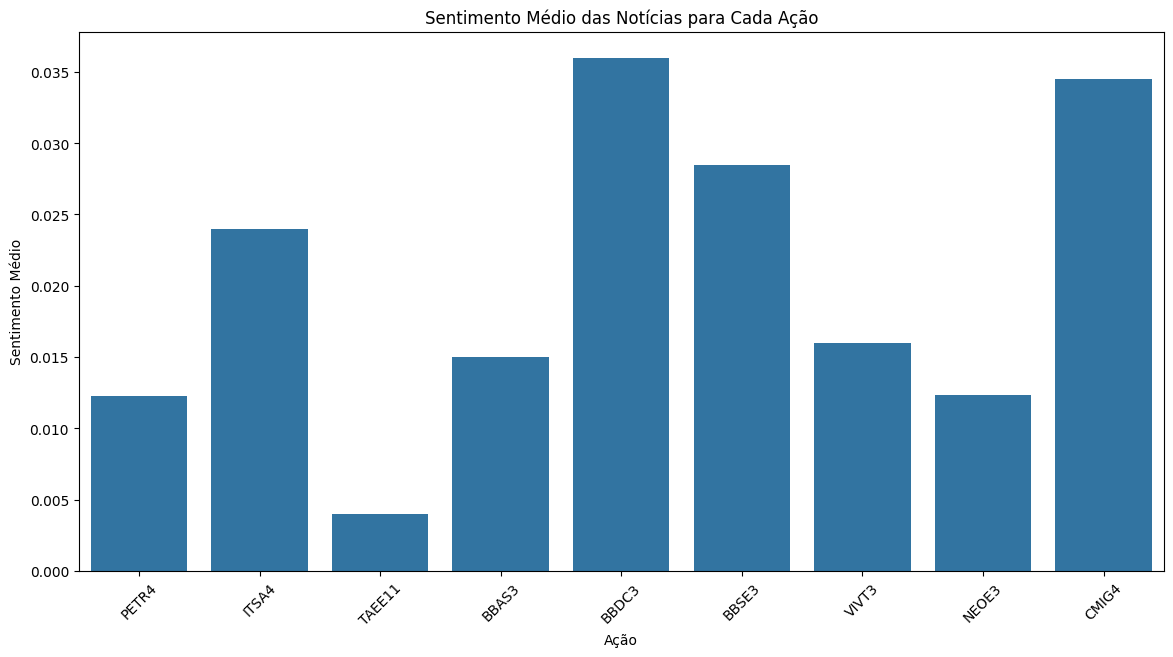

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotando os resultados
plt.figure(figsize=(14, 7))
sns.barplot(x='Ação', y='Sentimento Médio', data=df_sentimentos)
plt.title('Sentimento Médio das Notícias para Cada Ação')
plt.xlabel('Ação')
plt.ylabel('Sentimento Médio')
plt.xticks(rotation=45)
plt.show()

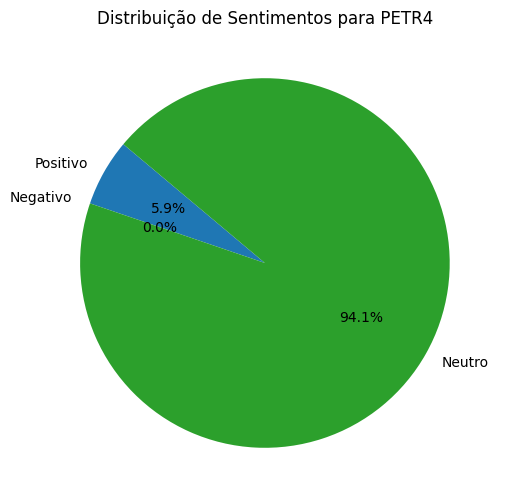

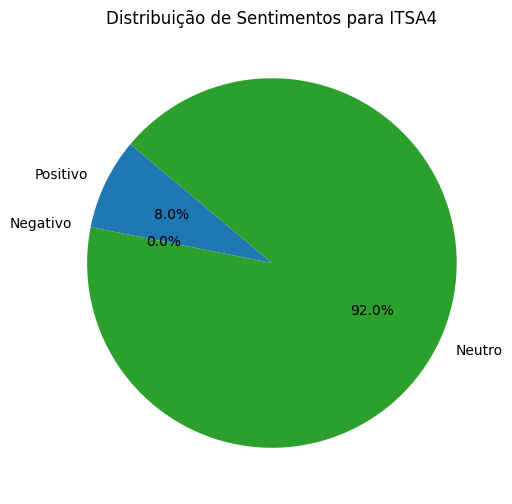

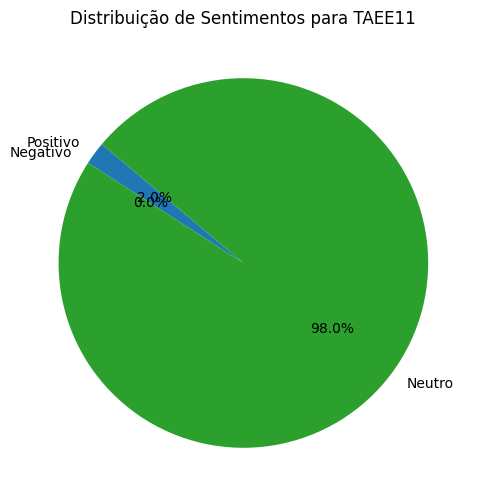

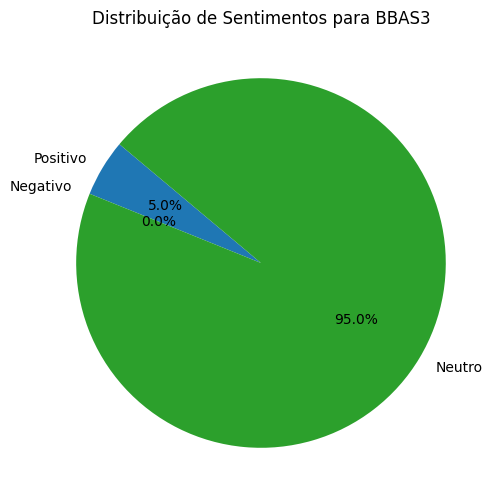

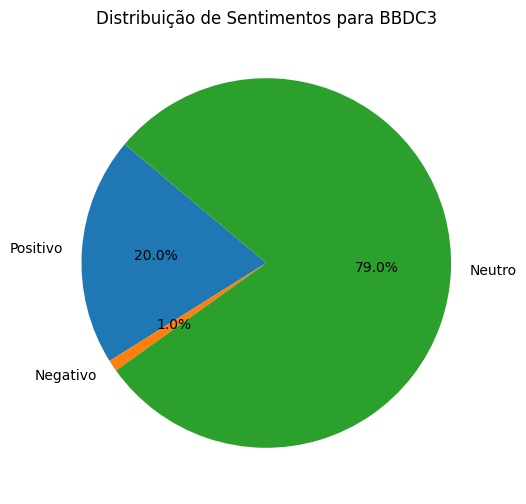

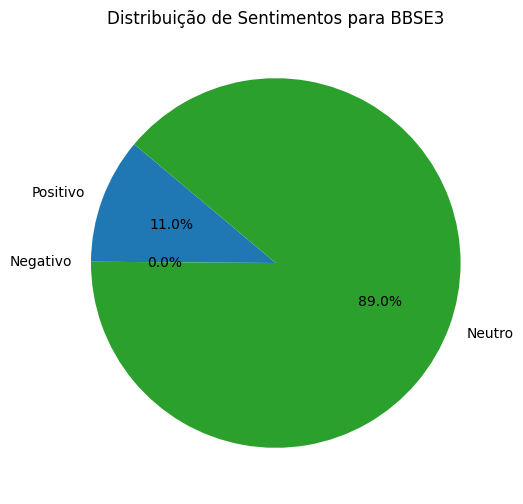

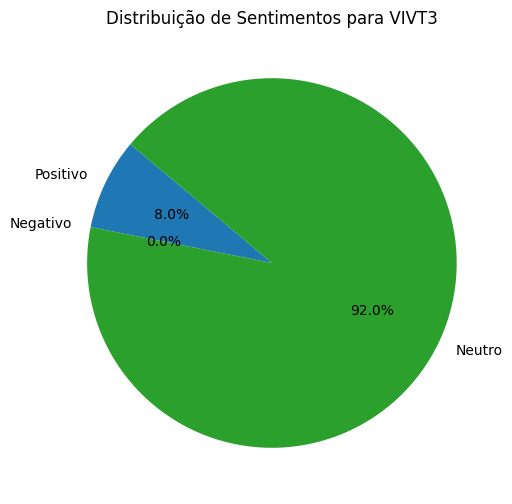

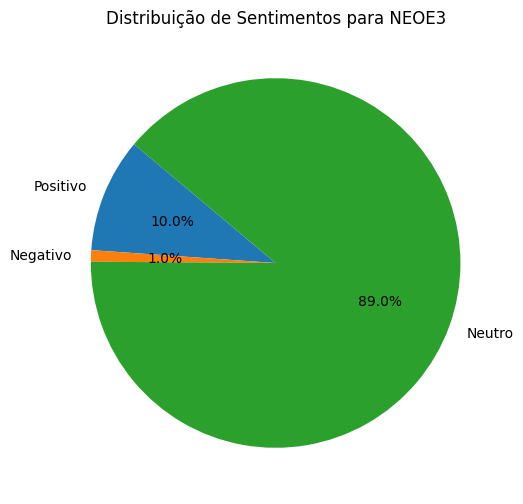

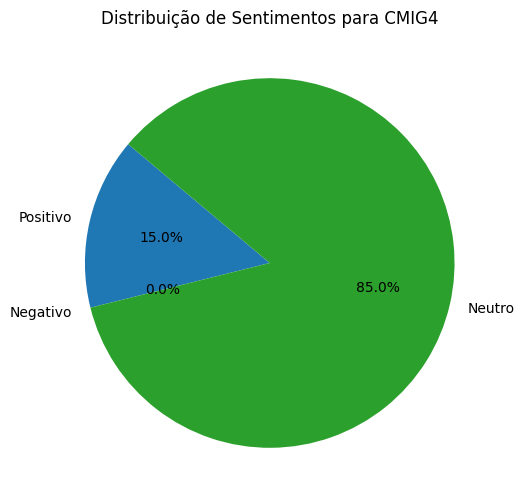

In [11]:
# Classificar sentimentos em positivo, negativo e neutro
def classificar_sentimentos(sentimentos):
    positivo = sum(1 for sentimento in sentimentos if sentimento > 0.1)
    negativo = sum(1 for sentimento in sentimentos if sentimento < -0.1)
    neutro = len(sentimentos) - positivo - negativo
    return [positivo, negativo, neutro]

# Classificar sentimentos para cada ação
classificacoes_sentimentos = {ticker: classificar_sentimentos(sentimentos[ticker]) for ticker in acoes}

# Visualizar resultados em gráficos de pizza
for acao, valores in classificacoes_sentimentos.items():
    plt.figure(figsize=(6, 6))
    plt.pie(valores, labels=['Positivo', 'Negativo', 'Neutro'], autopct='%1.1f%%', startangle=140)
    plt.title(f'Distribuição de Sentimentos para {acao}')
    plt.show()